# RDS Homework 2 Template
## Spring 2024


In [1]:
%pip install shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leoyaoair23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [4]:
# Initialize & fit tf-idf vectorizer
tfidfvect = TfidfVectorizer()
X_train = tfidfvect.fit_transform(newsgroups_train.data)
X_test = tfidfvect.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target
feats = tfidfvect.get_feature_names_out()

In [5]:
# Train & fit the classifier
clf = SGDClassifier(loss='log_loss', random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Part (B)

In [6]:
# Confusion Matrix
# use sklearn.metrics.confusion_matrix
conf_matrix = sklearn.metrics.confusion_matrix(y_pred, y_test)

print("                    Actual Atheism    Actual Christian")
print("Predicted Atheism           {}                 {}".format(conf_matrix[0][0], conf_matrix[0][1]))
print("Predicted Christian          {}               {}".format(conf_matrix[1][0], conf_matrix[1][1]))

                    Actual Atheism    Actual Christian
Predicted Atheism           276                 4
Predicted Christian          43               394


#### Explainer

In [7]:
# Initialize the explainer and apply to test data
explainer = shap.LinearExplainer(clf, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [8]:
# Find some correctly classified and misclassified examples
# Find one that correctly classifies as Christian
idx = 0
while (True):
    if y_test[idx] == class_names.index('christian'):
        if y_test[idx] == y_pred[idx]:
            break
    idx += 3
print("Correct Christian")
print("Index:", idx)
print("Predicted:", class_names[y_pred[idx]])
print("Actual:", class_names[y_test[idx]])
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Correct Christian
Index: 0
Predicted: christian
Actual: christian


In [9]:
# Find one that correctly classifies as Atheism
idx = 0
while (True):
    if y_test[idx] == class_names.index('atheism'):
        if y_test[idx] == y_pred[idx]:
            break
    idx += 3
print("Correct Atheist")
print("Index:", idx)
print("Predicted:", class_names[y_pred[idx]])
print("Actual:", class_names[y_test[idx]])
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Correct Atheist
Index: 9
Predicted: atheism
Actual: atheism


In [10]:
# Find one that misclassifies as Christian
idx = 0
while (True):
    if y_test[idx] == class_names.index('atheism'):
        if y_test[idx] != y_pred[idx]:
            break
    idx += 3
print("Incorrect Christian (misclassified as Christian)")
print("Index:", idx)
print("Predicted:", class_names[y_pred[idx]])
print("Actual:", class_names[y_test[idx]])
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Incorrect Christian (misclassified as Christian)
Index: 99
Predicted: christian
Actual: atheism


In [11]:
# Find one that misclassifies as Atheism
idx = 0
while (True):
    if y_test[idx] == class_names.index('christian'):
        if y_test[idx] != y_pred[idx]:
            break
    idx += 3
print("Incorrect Atheist (misclassified as Atheist)") 
print("Index:", idx)
print("Predicted:", class_names[y_pred[idx]])
print("Actual:", class_names[y_test[idx]])
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Incorrect Atheist (misclassified as Atheist)
Index: 54
Predicted: atheism
Actual: christian


In [12]:
# Find one random
np.random.seed(1)
idx = np.random.randint(0, X_test.shape[0])
print("Index:", idx)
print("Predicted:", class_names[y_pred[idx]])
print("Actual:", class_names[y_test[idx]])
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Index: 37
Predicted: christian
Actual: christian


### Part (C)


#### Part (i)

In [13]:
# Compute the accuracy of the classifier and the number of misclassified documents
print("Accuracy:", clf.score(X_test, y_test))
num_misclassified = conf_matrix[0][1] + conf_matrix[1][0]
print("Number of misclassified documents:", num_misclassified)

Accuracy: 0.9344490934449093
Number of misclassified documents: 47


#### Part (ii)

In [14]:
# Find the indices of the misclassified documents
idx_misclassified = np.where(y_test != y_pred)
print("Indices of misclassified documents:", idx_misclassified[0])

Indices of misclassified documents: [ 20  38  54  62  94  99 107 109 123 126 134 156 197 216 217 245 271 335
 366 377 399 406 413 419 438 447 461 469 473 558 568 591 605 607 610 615
 620 623 641 658 668 677 679 683 685 694 703]


In [15]:
# Check the misclassified documents
y_test_misclassified = y_test[idx_misclassified]
y_pred_misclassified = y_pred[idx_misclassified]
print(y_test_misclassified)
print(y_pred_misclassified)

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0]
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1]


In [16]:
# Calculate conf_i for all misclassified documents
# The dictionary has the index of the misclassified document as the key 
# The value is the difference between the probabilities of the two classes
conf = {}
for i in idx_misclassified[0]:
    probs = clf.predict_proba(X_test[i])
    conf[i] = abs(probs[0][0] - probs[0][1])

In [17]:
# Actual Atheism, misclassified as Christian
conf_actual_atheism = {}
for i in conf.keys():
    if y_test[i] == class_names.index('atheism'):
        conf_actual_atheism[i] = conf[i]

# Actual Christian, misclassified as Atheism
conf_actual_christian = {}
for i in conf.keys():
    if y_test[i] == class_names.index('christian'):
        conf_actual_christian[i] = conf[i]

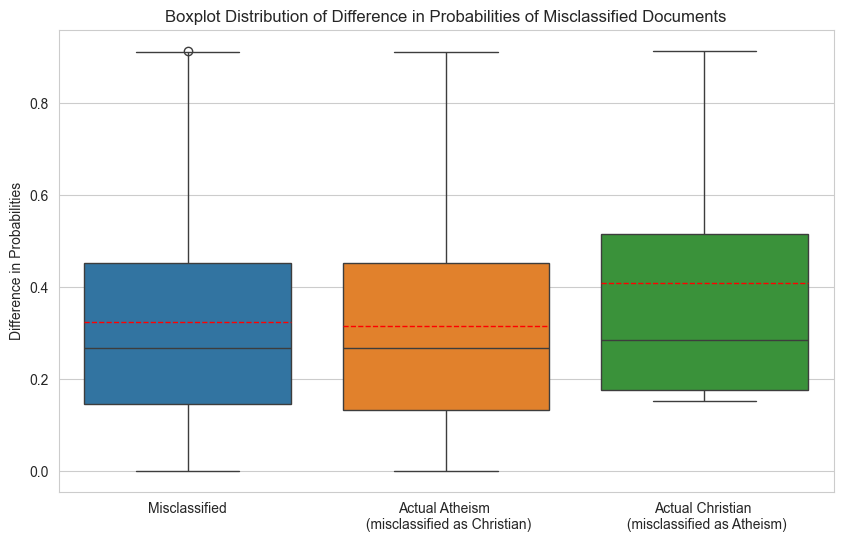

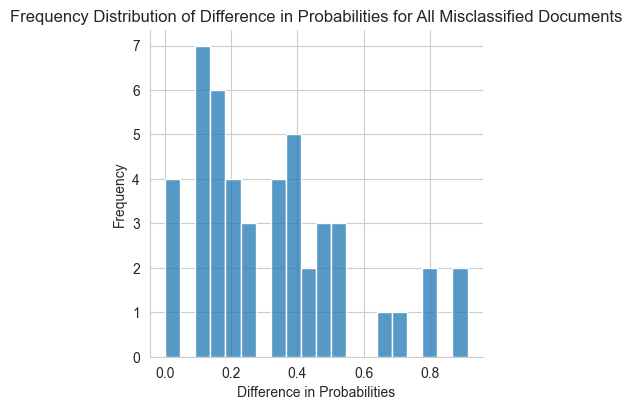

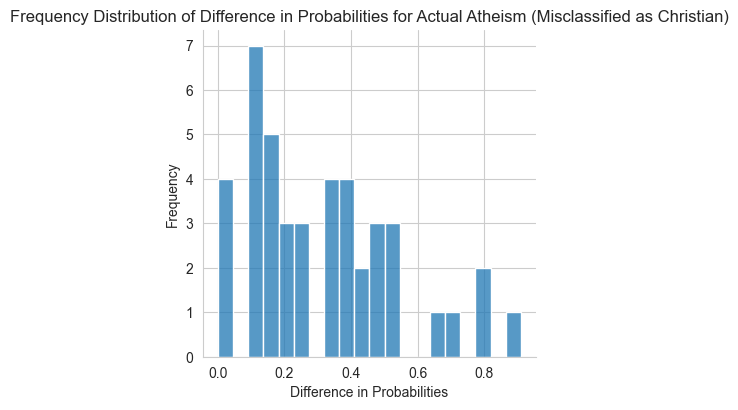

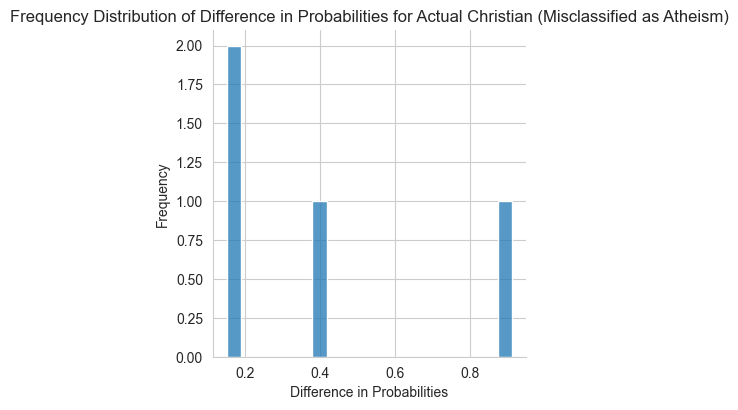

In [18]:
# Plot conf_i
plt.figure(dpi=100, figsize=(10, 6))
plt.title('Boxplot Distribution of Difference in Probabilities of Misclassified Documents')
sns.boxplot(data=[list(conf.values()), list(conf_actual_atheism.values()), list(conf_actual_christian.values())], showmeans=True, meanline=True, meanprops={'color': 'red', 'linestyle': '--'})
plt.xticks([0, 1, 2], ['Misclassified', 'Actual Atheism \n (misclassified as Christian)', 'Actual Christian \n (misclassified as Atheism)'])
plt.ylabel('Difference in Probabilities')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(list(conf.values()), columns=['Difference in Probabilities']), height=4, aspect=1)
fre.map(sns.histplot, 'Difference in Probabilities', bins=20)
fre.set_axis_labels('Difference in Probabilities', 'Frequency')
plt.title('Frequency Distribution of Difference in Probabilities for All Misclassified Documents')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(list(conf_actual_atheism.values()), columns=['Difference in Probabilities']), height=4, aspect=1)
fre.map(sns.histplot, 'Difference in Probabilities', bins=20)
fre.set_axis_labels('Difference in Probabilities', 'Frequency')
plt.title('Frequency Distribution of Difference in Probabilities for Actual Atheism (Misclassified as Christian)')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(list(conf_actual_christian.values()), columns=['Difference in Probabilities']), height=4, aspect=1)
fre.map(sns.histplot, 'Difference in Probabilities', bins=20)
fre.set_axis_labels('Difference in Probabilities', 'Frequency')
plt.title('Frequency Distribution of Difference in Probabilities for Actual Christian (Misclassified as Atheism)')
plt.show()

#### Part (iii)

In [19]:
# Identify tokens (word_j) that contributed to the misclassification of documents
# Compute the number of documents (count_j) these words helped to misclassify
# Compute the sum of absolute SHAP values (weight_j) for each word_j
# The key is the word/token/feature
# The value is a list that contains the count and the sum of absolute SHAP value
# The default is [0,0]
words = defaultdict(lambda: [0.0, 0.0])
words_actual_atheism = defaultdict(lambda: [0.0, 0.0])
words_actual_christian = defaultdict(lambda: [0.0, 0.0])
# Iterate through each misclassified document
for i in idx_misclassified[0]:
    actual = y_test[i]
    # Iterate through each word/token/feature in this document
    for j in range(X_test[i].shape[1]):
        word = feats[j]
        # Actual Atheism
        if actual == class_names.index('atheism'):
            # Check if the word is causing the misclassification
            # In this case, check if the SHAP value is positive
            # Causing it to be classified as Christian
            if shap_values[i,j] > 0:
                words_actual_atheism[word][0] += 1
                words_actual_atheism[word][1] += abs(shap_values[i,j])
            else: 
                # The word is not causing the misclassification
                # Skips the current iteration and moves to the next word
                # Avoiding add it to the total count and sum of absolute SHAP values
                continue
        # Actual Christian
        else:
            # Check if the SHAP value is negative, causing it to be classified as Atheism
            if shap_values[i,j] < 0:
                words_actual_christian[word][0] += 1
                words_actual_christian[word][1] += abs(shap_values[i,j])
            else:
                continue
        # Add 1 to the total count and sum of absolute SHAP values
        words[word][0] += 1
        words[word][1] += abs(shap_values[i,j])

In [20]:
# Convert the dictionaries to lists
counts = [words[i][0] for i in words.keys()]
counts_actual_atheism = [words_actual_atheism[i][0] for i in words_actual_atheism.keys()]
counts_actual_christian = [words_actual_christian[i][0] for i in words_actual_christian.keys()]
weights = [words[i][1] for i in words.keys()]
weights_actual_atheism = [words_actual_atheism[i][1] for i in words_actual_atheism.keys()]
weights_actual_christian = [words_actual_christian[i][1] for i in words_actual_christian.keys()]

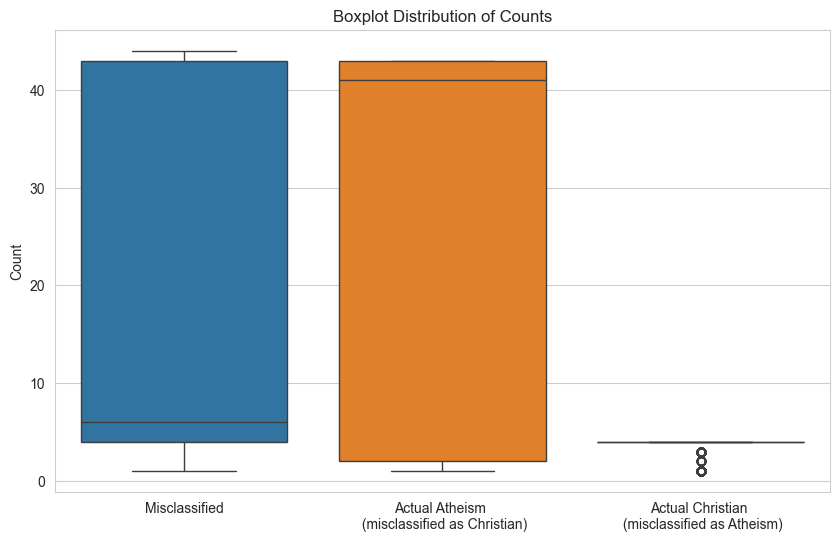

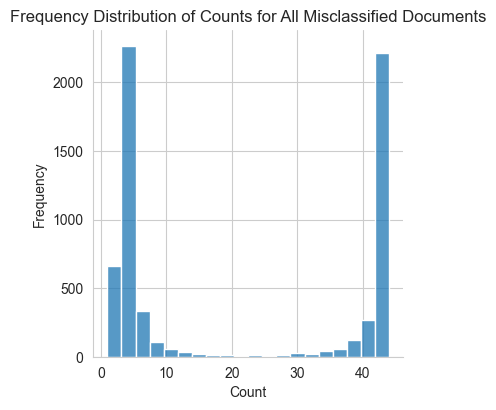

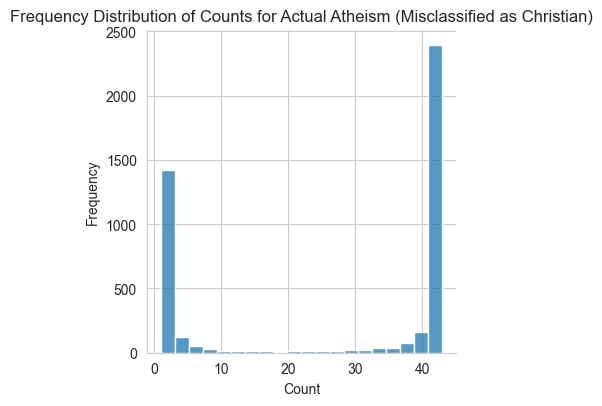

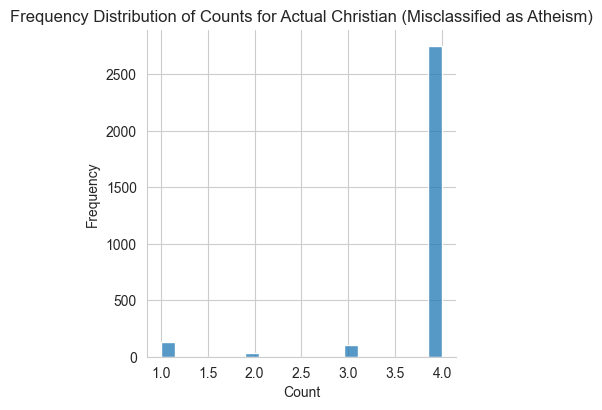

In [21]:
# Plot the distribution of count_j and weight_j
plt.figure(dpi=100, figsize=(10, 6))
plt.title('Boxplot Distribution of Counts')
sns.boxplot(data=[counts, counts_actual_atheism, counts_actual_christian])
plt.xticks([0, 1, 2], ['Misclassified', 'Actual Atheism \n (misclassified as Christian)', 'Actual Christian \n (misclassified as Atheism)'])
plt.ylabel('Count')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(counts, columns=['Count']), height=4, aspect=1)
fre.map(sns.histplot, 'Count', bins=20)
fre.set_axis_labels('Count', 'Frequency')
plt.title('Frequency Distribution of Counts for All Misclassified Documents')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(counts_actual_atheism, columns=['Count']), height=4, aspect=1)
fre.map(sns.histplot, 'Count', bins=20)
fre.set_axis_labels('Count', 'Frequency')
plt.title('Frequency Distribution of Counts for Actual Atheism (Misclassified as Christian)')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(counts_actual_christian, columns=['Count']), height=4, aspect=1)
fre.map(sns.histplot, 'Count', bins=20)
fre.set_axis_labels('Count', 'Frequency')
plt.title('Frequency Distribution of Counts for Actual Christian (Misclassified as Atheism)')
plt.show()

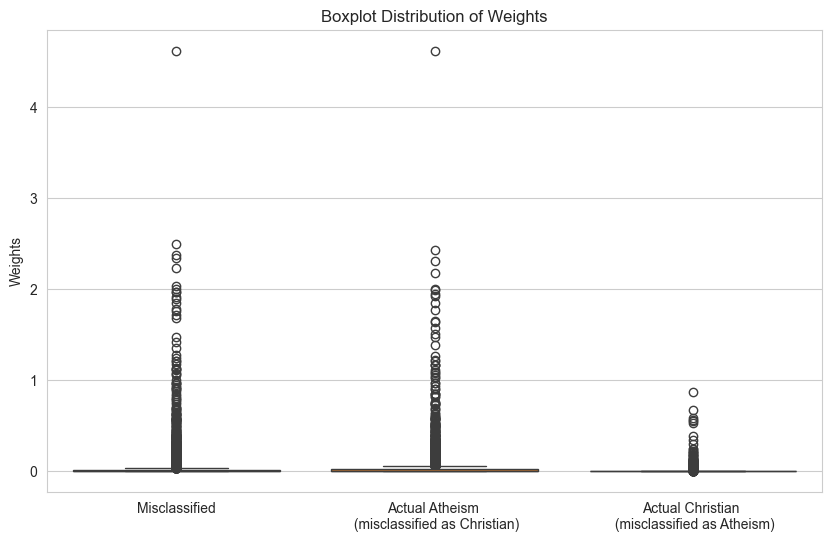

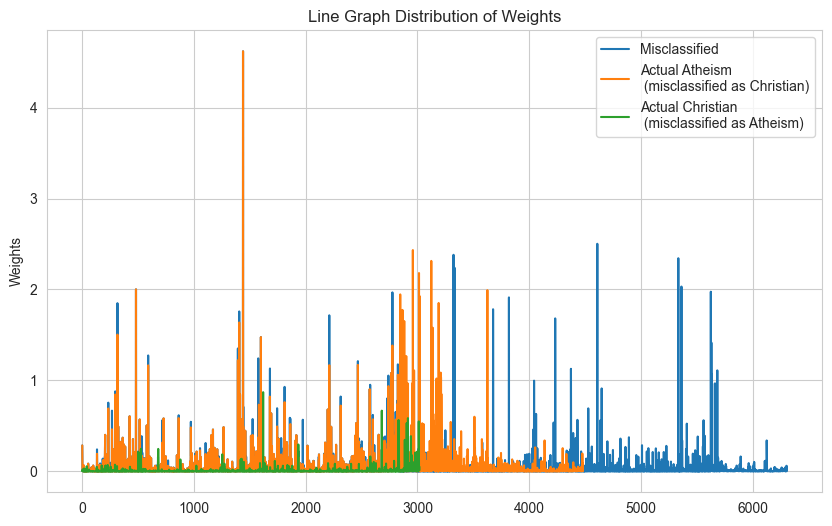

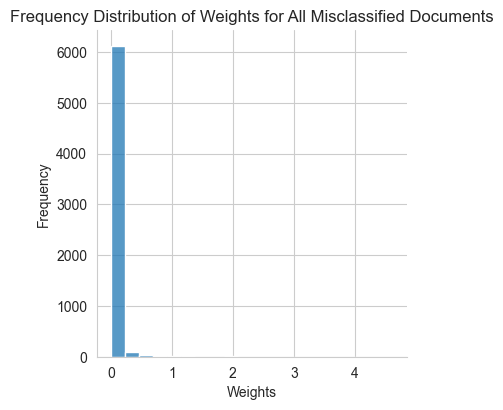

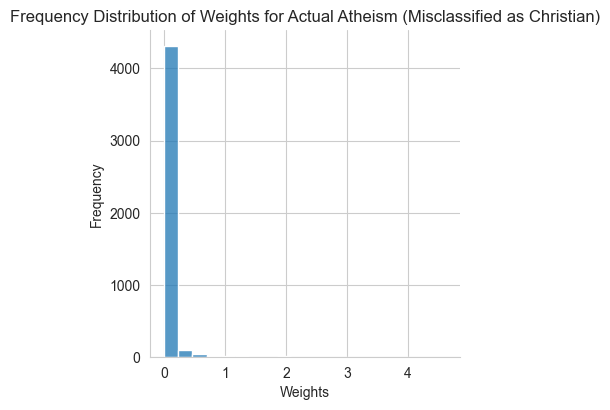

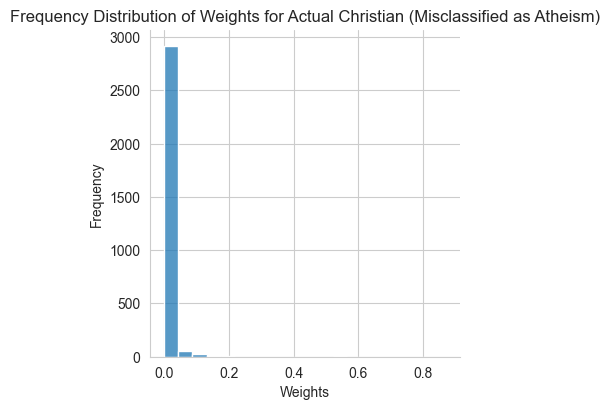

In [22]:
plt.figure(dpi=100, figsize=(10, 6))
plt.title('Boxplot Distribution of Weights')
sns.boxplot(data=[weights, weights_actual_atheism, weights_actual_christian])
plt.xticks([0, 1, 2], ['Misclassified', 'Actual Atheism \n (misclassified as Christian)', 'Actual Christian \n (misclassified as Atheism)'])
plt.ylabel('Weights')
plt.show()

plt.figure(dpi=100, figsize=(10, 6))
plt.title('Line Graph Distribution of Weights')
plt.plot(weights, label='Misclassified')
plt.plot(weights_actual_atheism, label='Actual Atheism \n (misclassified as Christian)')
plt.plot(weights_actual_christian, label='Actual Christian \n (misclassified as Atheism)')
plt.ylabel('Weights')
plt.legend()
plt.show()

fre = sns.FacetGrid(pd.DataFrame(weights, columns=['Weights']), height=4, aspect=1)
fre.map(sns.histplot, 'Weights', bins=20)
fre.set_axis_labels('Weights', 'Frequency')
plt.title('Frequency Distribution of Weights for All Misclassified Documents')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(weights_actual_atheism, columns=['Weights']), height=4, aspect=1)
fre.map(sns.histplot, 'Weights', bins=20)
fre.set_axis_labels('Weights', 'Frequency')
plt.title('Frequency Distribution of Weights for Actual Atheism (Misclassified as Christian)')
plt.show()

fre = sns.FacetGrid(pd.DataFrame(weights_actual_christian, columns=['Weights']), height=4, aspect=1)
fre.map(sns.histplot, 'Weights', bins=20)
fre.set_axis_labels('Weights', 'Frequency')
plt.title('Frequency Distribution of Weights for Actual Christian (Misclassified as Atheism)')
plt.show()

### Part (D)

In [23]:
# Implement a strategy for feature selection
# Select the top 10 words that contributed to the misclassification of documents
top_10_words = sorted(words.items(), key=lambda x: x[1][1], reverse=True)[:10]

# Remove them from the train/test data and vectorizer.get_feature_names_out()
indices_to_remove = []

print("Words to remove (and their indices):")
for word in top_10_words:
    idx = tfidfvect.vocabulary_[word[0]]
    indices_to_remove.append(idx)
    print(f"Word: {word[0]}, Index: {idx}")

indices_to_keep = [i for i in range(X_train.shape[1]) if i not in indices_to_remove]

Words to remove (and their indices):
Word: keith, Index: 10536
Word: of, Index: 12803
Word: christian, Index: 4272
Word: the, Index: 17689
Word: church, Index: 4303
Word: to, Index: 17912
Word: caltech, Index: 3806
Word: and, Index: 2255
Word: you, Index: 19598
Word: faith, Index: 7544


In [24]:
# Keep only the indices that are not in doc99_words
X_train_filtered = X_train[:, indices_to_keep]
X_test_filtered = X_test[:, indices_to_keep]
feats_filtered = [feats[i] for i in indices_to_keep]

In [25]:
clf.fit(X_train_filtered, y_train)
y_pred_filtered = clf.predict(X_test_filtered)
print("Accuracy:", clf.score(X_test_filtered, y_test))

Accuracy: 0.9400278940027894


In [26]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
explainer_filtered = shap.LinearExplainer(clf, X_train_filtered, feature_perturbation="interventional")
shap_values_filtered = explainer_filtered.shap_values(X_test_filtered)
X_test_filtered_array = X_test_filtered.toarray()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [27]:
idx = 62
print("Index:",idx)
print("Actual:", class_names[y_test[idx]])
print("Before Feature Selection")
print("Predicted:", class_names[y_pred[idx]])
print("After Feature Selection")
print("Predicted:", class_names[y_pred_filtered[idx]])

Index: 62
Actual: christian
Before Feature Selection
Predicted: atheism
After Feature Selection
Predicted: christian


In [28]:
print("Before Feature Selection")
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Before Feature Selection


In [29]:
print("After Feature Selection")
shap.force_plot(
    explainer_filtered.expected_value,
    shap_values_filtered[idx, :],
    X_test_filtered_array[idx, :],
    feature_names=feats_filtered
)

After Feature Selection


In [33]:
idx = 197
print("Index:",idx)
print("Actual:", class_names[y_test[idx]])
print("Before Feature Selection")
print("Predicted:", class_names[y_pred[idx]])
print("After Feature Selection")
print("Predicted:", class_names[y_pred_filtered[idx]])

Index: 197
Actual: atheism
Before Feature Selection
Predicted: christian
After Feature Selection
Predicted: atheism


In [31]:
print("Before Feature Selection")
shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_array[idx, :],
    feature_names=feats
)

Before Feature Selection


In [32]:
print("After Feature Selection")
shap.force_plot(
    explainer_filtered.expected_value,
    shap_values_filtered[idx, :],
    X_test_filtered_array[idx, :],
    feature_names=feats_filtered
)

After Feature Selection
